In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children = (), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self,), label="tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build_topo(child)
                topo.append(root)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [3]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

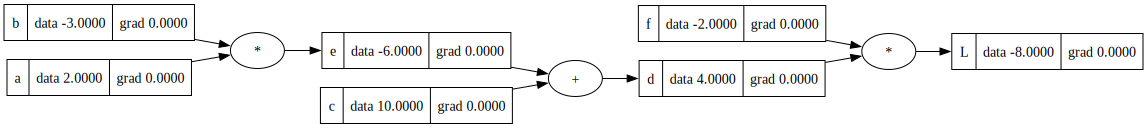

In [32]:
draw_dot(L)

In [12]:
L.grad = 1.0 # dl/dl =1 L = d*f
d.grad = -2.0 # dl/dd = f = -2
f.grad = 4.0 # dl/df = d = 4
e.grad = -2.0  # dl/de = dl/dd * dd/de = -2 * dd/de (d = e + c) -> dd/de = 1 => -2*1 = -2
c.grad = -2.0  # dl/dc = dl/dd * dd/dc = -2 * dd/dc (d = e + c) -> dd/dc = 1 => -2*1 = -2
a.grad =  6.0 # dl/da = dl/de * de/da = -2 * de/ da (e = a*b)- > de/da = b -> -2 * -3 = 6
b.grad =  -4.0 # dl/db = dl/de * de/db = -2 * de/ db (e = a*b)- > de/db = a -> -2 * 2 = 4

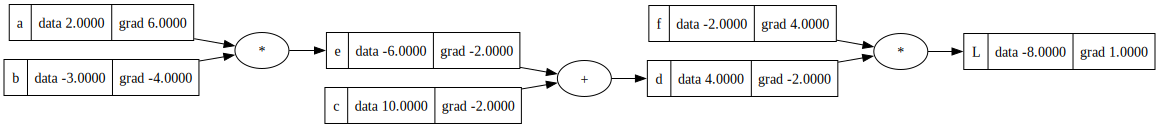

In [13]:
draw_dot(L)

In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad

e = a*b; 
d = e + c
L = d * f
print(L)

Value(data=-7.325695999999999)


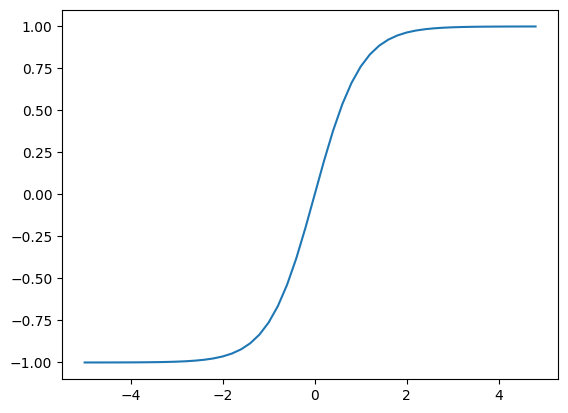

In [15]:
plt.plot(np.arange(-5, 5 ,0.2), np.tanh(np.arange(-5, 5,0.2)))

In [10]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 +b; n.label = "n"
out = n.tanh(); out.label = "out"

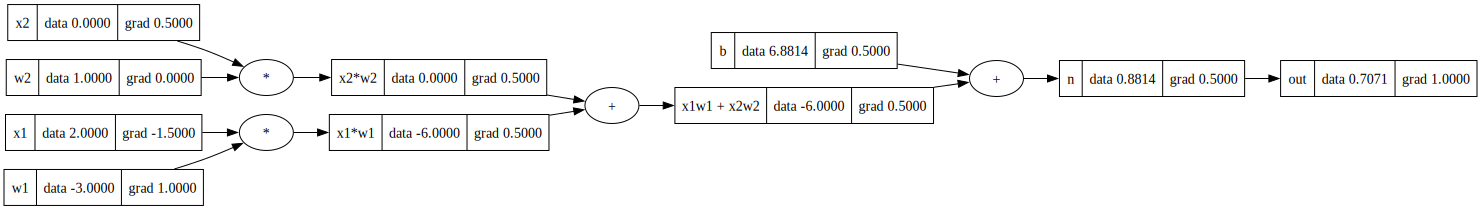

In [13]:
draw_dot(out)

In [12]:
out.backward()

In [6]:
topo = []
visited = set()
def build_topo(root):
    if root not in visited:
        visited.add(root)
        for child in root._prev:
            build_topo(child)
        topo.append(root)
build_topo(out)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [7]:
out.grad = 1.0
for node in reversed(topo):
    node._backward()

In [48]:
out.grad = 1.0
out._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

In [ ]:
# dout/d(z) = dout/dn * dn/dz (n = z + b) let's say z = x1w1 +x2w2 ==> dn/dz = 1

# dout/dx2 = dout/dn * dn/dz * dz/dx2 ( dz/dx2 = w2) ==> 0.5 * 1 * 1 = 0.5

# dout/dw2 = dout/dn * dn/dz * dz/dw2 ( dz/dw2 = x2) ==> 0.5 * 1 * 0 = 0

# dout/dx1 = dout/dn * dn/dz * dz/dx1 ( dz/dx1 = w1) ==> 0.5 * 1 * -3 = -1.5

# dout/dw1 = dout/dn * dn/dz * dz/dw1 ( dz/dw1 = x1) ==> 0.5 * 1 * 2 = 1


## 2nd HALF

In [43]:
class Value:
    def __init__(self, data, _children = (), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "supports only int and float"
        out = Value(self.data**other, (self,), f"**{other}")
        
        def _backward():
            self.grad += out.grad * other* (self.data**(other-1))
            
        out._backward = _backward
        return out
        
    
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self,), label="tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), label ="exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root._prev:
                    build_topo(child)
                topo.append(root)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [44]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 +b; n.label = "n"
#--------------------------------------
e = (2*n).exp()
out = (e-1)/(e+1); out.label = "out"

# n.tanh(); out.label = "out"
#--------------------------------------
out.backward()

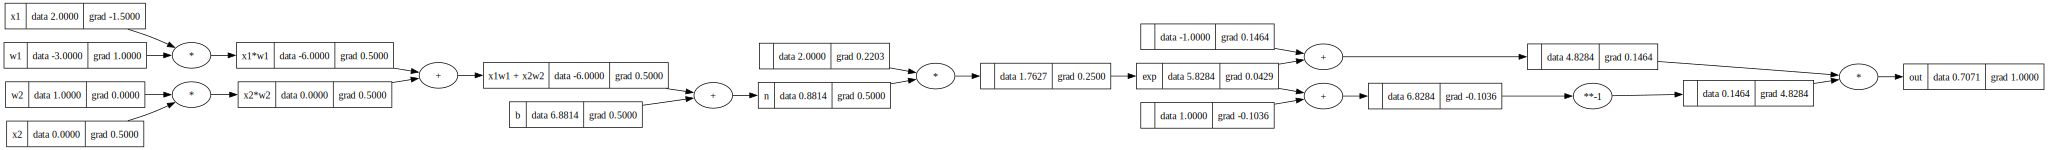

In [45]:
draw_dot(out)

In [47]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.tensor([0]).double(); x2.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

n = ((x1*w1) + (x2*w2)) + b
o = torch.tanh(n)
o.backward()

print("Out", o.data.item())


print("X1 grad", x1.grad.item())
print("W1 grad", w1.grad.item())
print("W2 grad", w2.grad.item())
print("X2 grad", x2.grad.item())

Out 0.7071066904050358
X1 grad -1.5000003851533106
W1 grad 1.0000002567688737
W2 grad 0.0
X2 grad 0.5000001283844369


In [274]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [275]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.7914546364810675)

In [276]:
xs = [[2.0, 3.0, -1.0],
     [4.0, 5.0, -2.0],
     [3.0, -4.0, 6.0],
     [5.0, -3.0, 1.0]]

ys = [1.0, -1.0, -1.0, 1.0]

In [277]:
for i in range(20):
    # forward pass

    ypred = [n(x) for x in xs]
    loss = sum([(yp-yt)**2 for yt, yp in zip(ys, ypred)])
    
    # reset grad to 0 as Value class accumulates the grad -- after the forward pass
    for p in n.parameters:
        p.grad = 0.0
    
    # backward pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data+= -0.05* p.grad
        
    print(i, loss.data)

0 6.538685666282344
1 5.509524405182168
2 3.7712119167517963
3 4.572340950908077
4 4.49694952481019
5 4.128807406494524
6 3.3745033924021586
7 5.509482846797786
8 5.53105544985076
9 4.862070135382721
10 4.092333684915054
11 4.220982519839676
12 4.782697693657514
13 5.114115551534249
14 4.862595024801703
15 4.2740312441086346
16 4.143236263440855
17 4.311976661355131
18 4.028018232537839
19 4.298610680804408


In [85]:
loss.backward()

In [86]:
loss

Value(data=4.067743885213256)

In [271]:
ypred = [n(x) for x in xs]
loss = sum([(yp-yt)**2 for yt, yp in zip(ys, ypred)])
loss

Value(data=6.022575461844729)

In [272]:
loss.backward()

In [131]:
ypred

[Value(data=0.11422350186772029),
 Value(data=0.10313376928604517),
 Value(data=-0.7426004686828701),
 Value(data=0.85674699768694)]